## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 

import scipy.signal

# sampling rate
fs = 125

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    # only return the ppg, x, y, z 
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
#     print(errs, confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    # based on Udacity class notes
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    # NEW
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Estimates pulse rate and Confidence  
    
    Args: 
        date_fl: (str) filepath to troika *.mat file 
    Returns: 
        errors: Calculated errors for each heart rate 
        Confidence: Calculated Confidence for each heart rate 
    """
    # Load data using LoadTroikaDataFile
    # photoplethysmogram (PPG) 
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    #print(ppg)
    
    # Compute pulse rate estimates and estimation confidence.
    # NEW
    
    # All signals were sampled at 125 Hz.
    fs = 125 
    
    # win_len 
    # total time 12 sec; 8 win_len will give a sliding windows 
    # [0-8), [2-10), [4-12) based on discussion forum discussion
    win_len = 8 
    
    # win_shift
    win_shift = 2
    nfft_window = fs * 8 
    noverlap = fs * 6 
    
    # filter the signal
    filtered_ppg = BandpassFilter(ppg, (40/60.0,240/60.0), fs=fs)   

    accx = BandpassFilter(accx, (40/60.0,240/60.0), fs=fs)
    accy = BandpassFilter(accy, (40/60.0,240/60.0), fs=fs) 
    accz = BandpassFilter(accz, (40/60.0,240/60.0), fs=fs) 
    
    # acc magnitude based on accelerometer deep-dive lecture 
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # extract the ground truth as a flattened vector 
    true_vals = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    # call predict_heart_rate to get predictions and confidence 
    predictions, confidence = predict_heart_rate(acc, ppg, fs)

    errors = np.abs(predictions - true_vals)
    
    # estimate errors and confidence and return them
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    # errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    
    return np.array(errors), np.array(confidence)


def FT(acc_s, fs):
    """
    Take a Fourier Transform (FT) of a signal and return the frequencies
    Args: 
        accx: (numpy array) signal 
        fs: (int) Sampling frequency in Hertz 
    Returns: 
        fft: (float) FT magnitudes
        freqs: (numpy array) frequencies 
    """
    # NEW
    
    # based on activity_classifier_utils.py code and class notes
    # ** zero padding gives better results **
    # ** Any other choice (see below) failed the test ***
    # fft_len = len(acc_s) * 4
    # fft_len = max(len(acc_s), 2046)
    fft_len = len(acc_s)
    
    # create an array of frequency bins 
    fft_freqs = np.fft.rfftfreq(fft_len, 1/fs)
    
    fft = np.fft.rfft(acc_s, fft_len)
    fft = np.abs(fft)
    
    return fft_freqs, fft
    
def predict_heart_rate(acc, ppg, fs,
                       window_len = 8, 
                       window_shift = 2, 
                       min_bp = 40/60.0, 
                       max_bp = 240/60.0 ):
    
#     estimates pulse rate from the PPG signal and a 3-axis accelerometer. 
#     assumes pulse rate will be restricted between 40 BPM (min_bp; beats per minute) and 240 BPM
#     produces an estimation confidence. A higher confidence value means that this 
#     (max_bp) estimate should be more accurate than an estimate with a lower confidence value.
#     produces an output at least every 2 seconds.

#   

    # create empty list to add later 
    confidence = []
    bpm0_pred = []
    
    window_len = window_len * fs 
    window_shift = window_shift * fs 
    # MAE was higher
    window_hw = 1
    # window_hw = 40.0/60.0 # didnt work
    
    # loop over the samples
    
    wfrom = len(ppg) - window_len + 1 
    wto = window_shift
    
    for i in range(0, wfrom, wto ): 
        
        # Let us now focus on the current window 
        ppg_w = ppg[i:i+window_len]
        acc_w = acc[i:i+window_len]
        
        #Let us do FT 
        ppg_fs, ppg_fft = FT(ppg_w, fs)
        acc_fs, acc_fft = FT(acc_w, fs)
        
        # restrict to only pulse rate indicated by the paper 
        # Remember to bandpass filter all your signals. 
        # Use the 40-240BPM range to create your pass band.

        acc_fft[acc_fs <= min_bp] = 0.0
        acc_fft[acc_fs >= max_bp] = 0.0
        
        ppg_fft[ppg_fs <= min_bp] = 0.0
        ppg_fft[ppg_fs >= max_bp] = 0.0
        
        
        # You can plot your estimates on top of the spectrogram to 
        # see where things are going wrong.
        
#         plt.figure(figsize=(12,8))
#         plt.specgram(acc_fft, Fs=fs, NFFT=250, noverlap=125, 
#                     xextent=[0, len(acc_fft)/fs/60])
#         plt.show()
        
        # When the dominant accelerometer frequency is 
        # the same as the PPG, try picking the next strongest PPG 
        # frequency if there is another good candidate.
        
        ppg_freq = ppg_fs[np.argmax(ppg_fft, axis=0)]
        acc_freq = acc_fs[np.argmax(acc_fft, axis=0)]
        
        ffreq = ppg_freq
        # Confidence calculator 
        # take ppg_fft, ppg_freq and ppg_fs
        
        cond1 = (ppg_fs >= ppg_freq - window_hw) 
        cond2 = (ppg_fs <= ppg_freq + window_hw)
#       w = (ppg_fs > ppg_freq - window_hw)  & (ppg_fs < ppg_freq + window_hw)
        w = cond1 & cond2
        abs_ppg_fft = np.abs(ppg_fft)
        conf = np.sum(abs_ppg_fft[w])/np.sum(abs_ppg_fft)
        # check to see whether the freq are the same 
        
        if abs(ppg_freq - acc_freq) == 0:
            # pick the next strongest one 
            temp_freq = ppg_fs[np.argsort(ppg_fft,axis=0)[-2]]
            # cal new conf
            cond1 = (ppg_fs >= temp_freq - window_hw) 
            cond2 = (ppg_fs <= temp_freq + window_hw)
            w = cond1 & cond2
            abs_ppg_fft = np.abs(ppg_fft)
            temp_conf = np.sum(abs_ppg_fft[w])/np.sum(abs_ppg_fft)
            
            if (temp_conf > conf):
                ffreq = temp_freq
                conf = temp_conf
            
        bpm0_pred.append(ffreq * 60) 
        confidence.append(conf)
    
    return bpm0_pred, confidence

 
    
    
    

## Testing dataset

Dataset contains 12 persons' PPG and three dimensions(x, y, z) accelerometer signal values. All subjects are male and they are between 18-35 years old. The data collected by wearing a wrist device while resting(30 sec) walking, running(4 min) and during a brief cooldown(30 sec) on a treadmill. All signals were sampled at 125 Hz.

Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. The first
row is a simultaneous recording of ECG, which is recorded from the chest of each subject. The
second row and the third row are two channels of PPG, which are recorded from the wrist of each
subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis). 

In [3]:
data_fls, ref_fls = LoadTroikaDataset()

In [4]:
LoadTroikaDataFile('./datasets/troika/training_data/DATA_01_TYPE01.mat')

array([[  4.00000000e+00,   6.00000000e+00,   3.00000000e+00, ...,
          8.60000000e+01,   1.04000000e+02,   1.18500000e+02],
       [ -7.02000000e-02,  -7.02000000e-02,  -5.46000000e-02, ...,
          4.13400000e-01,   4.13400000e-01,   4.13400000e-01],
       [  3.43200000e-01,   3.58800000e-01,   3.66600000e-01, ...,
         -2.80800000e-01,  -2.73000000e-01,  -2.73000000e-01],
       [  9.59400000e-01,   9.43800000e-01,   9.36000000e-01, ...,
          7.25400000e-01,   7.17600000e-01,   7.25400000e-01]])

In [5]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [6]:
scipy.io.loadmat('./datasets/troika/training_data/REF_01_TYPE01.mat')['BPM0'].shape

(148, 1)

In [7]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

In [8]:
# flatten 
GT = scipy.io.loadmat('./datasets/troika/training_data/REF_01_TYPE01.mat')['BPM0'].reshape(-1)
print(GT[0:10])
print(GT.shape)
print(GT.dtype)


[ 74.33920705  76.35746606  77.14285714  74.66814159  72.58064516
  71.68458781  72.89416847  73.44940152  75.33482143  76.8442623 ]
(148,)
float64


In [9]:
from scipy.io import loadmat

data_set = loadmat("./datasets/troika/training_data/DATA_01_TYPE01.mat")
print(data_set)
print(data_set.keys())

rows = data_set['sig']
print(rows.dtype)

rows.shape

round(37937 / fs / 60)  # 5 minutes 

# Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. 
rows.shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:04:51 2014', '__version__': '1.0', '__globals__': [], 'sig': array([[ -2.69500000e+02,  -2.67500000e+02,  -2.67500000e+02, ...,
         -1.88500000e+02,  -2.09000000e+02,  -2.32000000e+02],
       [ -2.30000000e+01,  -2.40000000e+01,  -2.65000000e+01, ...,
          6.70000000e+01,   8.45000000e+01,   1.00000000e+02],
       [  4.00000000e+00,   6.00000000e+00,   3.00000000e+00, ...,
          8.60000000e+01,   1.04000000e+02,   1.18500000e+02],
       [ -7.02000000e-02,  -7.02000000e-02,  -5.46000000e-02, ...,
          4.13400000e-01,   4.13400000e-01,   4.13400000e-01],
       [  3.43200000e-01,   3.58800000e-01,   3.66600000e-01, ...,
         -2.80800000e-01,  -2.73000000e-01,  -2.73000000e-01],
       [  9.59400000e-01,   9.43800000e-01,   9.36000000e-01, ...,
          7.25400000e-01,   7.17600000e-01,   7.25400000e-01]])}
dict_keys(['__header__', '__version__', '__globals__', 'sig'])
float64


(6, 37937)

In [10]:
data_01 = LoadTroikaDataFile('./datasets/troika/training_data/DATA_01_TYPE01.mat')
print(data_01.shape)

(4, 37937)


## Evaluate the Pulse Rate Algorithm

In [11]:
Evaluate()

16.566236642584752

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...



## List of installed packages 
Please check the list in `packagews_list_conda.txt` or `packages_list_pip.txt` 

In [12]:
!conda list > packages_list_conda.txt
!pip list > packages_list_pip.txt

## Code description 

Code estimates pulse rate from the PPG signal and a 3-axis accelerometer. The code chunks can be found above. The main calculation is carried out by the function, `Evaluate`, which subsequently calls other helper functions like Fourier Transform etc. 

## Data Description 

Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.

(The following information was gleaned from Zhilin Zhang's notes; also check the publication, Zhang et al, DOI: 10.1109/TBME.2014.2359372)

* Data the two-channel PPG signals, 3-axis acceleration signals, and one-channel ECG signals were simulatenously recorded from subjects with age from 18-35 years old.

For each subjects, 
* PPG signals were recorded from wrist by 2 pulse oximeters with green LEDs (wavelength = 515 nm). 
* The acceleration signal was recorded from wrist by a 3-axis accelerator. 
* ECG signal was recorded simultaneously from the chest using wet ECG sensors. 
* All signals were sampled at 125 HZ 

## Dataset information:

* All the data is present under the directory, `training_data`. 
* Note the TYPE01 or TYPE02 indicate the following traing types: 

```
TYPE01: Each subject ran on a treatmill with changing speeds as follows: rest(30s) -> 8 km/h (1 min) -> 12km/h (1 min) -> 8 km/h (1m) -> 15 km/h (1 min) -> rest (30s) 

TYPE02: Each subject ran on a treatmill with changing speeds as follows: rest(30s) -> 6 km/h (1 min) -> 12km/h (1 min) -> 6 km/h (1m) -> 12 km/h (1 min) -> rest (30s)   
```
`DATA_*.mat` contains the training data and `REF_*.mat` contains the ground-truth data 

```
['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']
 ```
 
 The files contin the REF labels contain ground truth heart pulse rates calculated from ECG measurements. 
 ```
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']
 ```

* `DATA*TYPE*.mat files contain a variable called 'sig'. 
    1) The sig contains 6 rows. 
    2) The first row is a simultaneous recording of ECG.
    3) The 2-3 row contains the two channels of PPG (recorded from the wrist of the patient)
    4) The last 3 rows are acceleration data (x, y and z respectively)

The difficulty is the PPG data include the following noise sources (Melanin, Arm motion, Arm Position, Finger motion, Sensor displacement and Ambiant light). We can use Fourier transformation and other signal processing techniques to filter and clean the data.      
    
Please read the Readme.pdf from the sub-directory, `/datasets/troika/training_data` for details.

## Algorithm Description 
Explain how the algorithm works
the specific aspects of the physiology that it takes advantage of
a description of the algorithm outputs
caveats on algorithm outputs, common failure modes

* Algorithm overview:
    * First the code reads the training and reference data
    * After reading the reading data (PPG and accelerometer signals), each signal will be passed through the filter to remove signals that fall outside of 40 BPM (beats/min) and 240 BPM frequencies. The reason is pulse rate is expected to fall within this range. 
    * Next, we calculate frequencies in 8s window (with 6s overlap with neighboring window). This is done because the ground-truth heart rate is stored in a 8s windows (with two sucessive time windows overlap by 6s).The goal is to estimate pulse rate using PPG. We use accelerometer data to differentiate the hand/body movement signals from heart pulse rate.  
        * Here are the details: 
          a) Take a small window, and do FT to identify the prominent peaks and see whether these peaks are also present in accelerometer signals. We need to remove them because, the peaks found between these signals do not correspond to heart rate but to arm/body motion. Compare the frequencies for the PPG signal with that of the accerometer signals. If the top frequency is similar in PPG and accelerometer, the compare upto 5 or more frequencies to see which PPG frequency is not similar to that of accelerometer frequncies.If no frquency can be found, then choose the largest frequency and call that as the heart pulse rate.  
    * After identifying the pulse rate frequncy (convert BPS to BPM) 
    * Estimate the confidence of the pulse rate 
    * Estimate the absolute error betweee the estimated pulse rate and the reference (ECG) pulse rate. 
        * This is done by taking the sum of intensiy magniture (around the characteristic frequency) divided by sum of intensity magnitures of all frequencies.
    * Return the pulse rate, errors (mean absolute error) and confidence 
    
There are several factors (see dataset information section for details) that could impact the quality of algorithm. The most important one is the temperature. Please check the following publication (PMID: 31248022) for details. 

To run the code, just run the `Evaluation` function. This function will estimate heart pulse rate and return the results. 

## Algorithm Performance 

Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

* The algorithm performance was evaluated using train-test split. 
* Criteria for performance is to get a mean absolute error at 90% availability to be less than 15 BPM on a withheld test data. 
    * This means the best 90% estimates -according to our confidence output-must have a MAE of less than 15 BPM. Our sucess criteria outcome was 9.5 BPM.

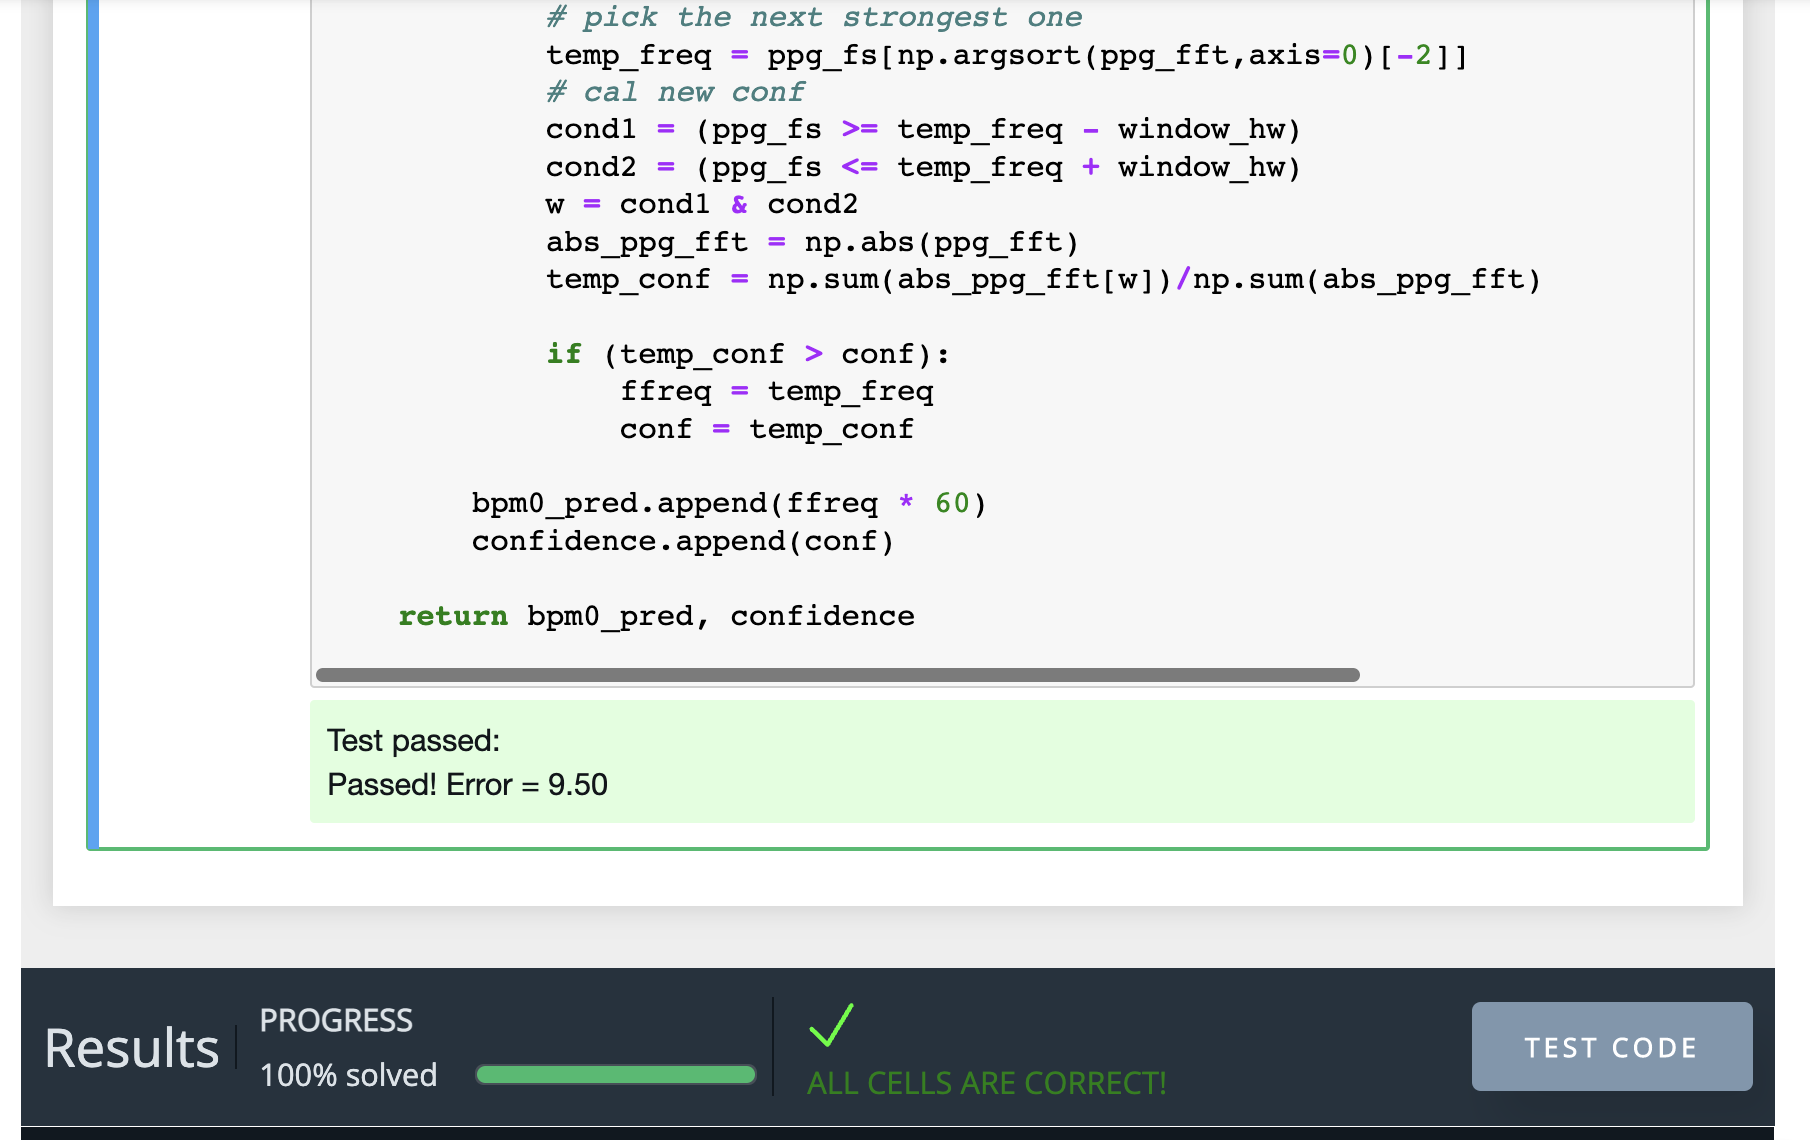

In [2]:
from IPython.display import Image
Image(filename='performance_pass_result.png')

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 